<h1>TAREA 4 - Filtrado de Imágenes en el Dominio Espacial</h1>
<h2>Sergio Alejandro Diaz Pinilla</h2>
<h2>Julian Camilo Mendez Corredor</h2>
<br>
<br>
<h2>Punto 1</h2>

<h3>TAREA.</h3>
<li>1. Implementar, en OpenCV, tres de los filtros para reducción de ruido Speckle vistos en clase.</li>


<h1 style="font-size:100%; background-color:rgba(70, 0, 700, 0.2); color:black; text-align:center; line-height : 30px;">
Visión de Máquina &#8212; F. Prieto </h1>


In [3]:
%matplotlib inline
import cv2
import time
from IPython.display import Image
import numpy as np
from matplotlib import pyplot as plt
from __future__ import division


img = cv2.imread('Fig/face.png',0)
print "Listo"


Listo


In [9]:
def speckle(img,mean=128,std=30):
    gaussian_noise = np.zeros(img.shape)
    noise = cv2.randn(gaussian_noise,mean,std);
    return img*noise
print "Listo"

Listo


In [10]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from scipy.stats import variation


def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    k = img_variance**2 / (img_variance**2 + overall_variance**2)
    img_output = img_mean + k * (img - img_mean)
    return img_output


def kuan_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    L = (img.std()/img.mean())**2
    
    overall_variance = (L*img_variance - img_mean**2) /(L+1)

    up = (img_variance**2) * (img - img_mean)
    down = img_variance**2 + (img_mean + img_variance**2)/L
    
    img_output = img_mean + up/down
    return img_output

def frost_coeff(window_flat, factor_A, window):
    """
    Compute all the weights of pixels in the window.
    """
    N, M = window.shape
    center_pixel = np.float64(window[int(N / 2), int(M / 2)])
    window_flat = np.float64(window_flat)
    distances = np.abs(window_flat - center_pixel)
    weights = np.exp(-factor_A * distances)
    return weights


def frost_filter(img, damping_factor=2.0, win_size=3):
    """
    Apply frost filter to a numpy matrix containing the image, with a window of
    win_size x win_size.
    By default, the window size is 3x3.
    """
    img_filtered = np.zeros_like(img)
    N, M = img.shape
    win_offset = win_size / 2

    for i in xrange(0, N):
        xleft = i - win_offset
        xright = i + win_offset
        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N - 1
        for j in xrange(0, M):
            yup = j - win_offset
            ydown = j + win_offset
            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M - 1

            # inspired by http://www.pcigeomatics.com/cgi-bin/pcihlp/FFROST
            window = img[int(xleft):int(xright), int(yup):int(ydown)] 
            sigma_zero = variation(window, None) / window.mean()  # var / u^2
            factor_A = damping_factor * sigma_zero
            pixels_array = window.flatten()
            weights_array = np.zeros(window.size)            
            weights_array = frost_coeff(pixels_array, factor_A, window)            
            
            weighted_values = weights_array * pixels_array
            img_filtered[i, j] = weighted_values.sum() / weights_array.sum()

    return img_filtered




<h2>Punto 2</h2>


<li>Implementar, en OpenCV, cinco de las técnicas de estimación del nivel de ruido vistas en clase.</li>
<h1 style="font-size:100%; background-color:rgba(70, 0, 700, 0.2); color:black; text-align:center; line-height : 30px;"></h1>

In [11]:
def snr(img):
    img_std = img.std()
    if(img_std == 0):
        img_std = 0.000000001
    return img.mean()/img_std

def enl(img):
    return snr(img)**2

def ssi(noise,filtered):
    noise_std = noise.std()
    if(noise_std == 0):
        noise_std = 0.000000001
    return (filtered.std()/filtered.mean()) * (noise.mean()/ noise_std)

def smpi(noise,filtered):
    m0 = 1+ np.abs(noise.mean() - filtered.mean())
    noise_std = noise.std()
    if(noise_std == 0):
        noise_std = 0.000000001
    return m0 * (filtered.std()/noise_std)

def quality(noise,filtered):
    ys = noise.mean() - np.abs(noise.mean() - filtered.mean())
    var = variance(filtered)
    if(var == 0):
        var = 0.000000001
    L0 = enl(noise)
    return (ys**2)/(L0*var)

# cx y cy escala de la cordenada
def all_mesoures(filtered,original,noise,cx=0.5,cy=0.5,winS=10):
    # Medidas de desempeno

    w,h = original.shape
    w = int(w*cx)
    h = int(h*cy)

    ori = original[w-winS:w+winS,h-winS:h+winS]
    
    lee = filtered[0]
    kuan = filtered[1]
    frost = filtered[2]

    win_img_or = noise[w-winS:w+winS,h-winS:h+winS]

    
    win_lee_S = lee[w-winS:w+winS,h-winS:h+winS]
    win_kuan_S = kuan[w-winS:w+winS,h-winS:h+winS]
    win_frost_S =frost[w-winS:w+winS,h-winS:h+winS]
    
    print "#---------------------------------------------------------------------------------------------------------#"
    print "#   \t\t\t\tLEE\t\t\t\tKUAN\t\t\t\tFROST"
    print "SNR\t\t\t\t"+str(snr(lee))+"\t\t\t"+str(snr(kuan))+"\t\t\t"+str(snr(frost))
    print "ENL\t\t\t\t"+str(enl(win_lee_S))+"\t\t\t"+str(enl(win_kuan_S))+"\t\t\t"+str(enl(win_frost_S))
    #print "SSI\t\t\t\t"+str(ssi(original,lee))+"\t\t\t"+str(ssi(original,kuan))+"\t\t\t"+str(ssi(original,frost))
    print "SSI\t\t\t\t"+str(ssi(win_img_or,win_lee_S))+"\t\t\t"+str(ssi(win_img_or,win_kuan_S))+"\t\t\t"+str(ssi(win_img_or,win_frost_S))
    print "SMPI\t\t\t\t"+str(smpi(win_img_or,win_lee_S))+"\t\t\t"+str(smpi(win_img_or,win_kuan_S))+"\t\t\t"+str(smpi(win_img_or,win_frost_S))
    print "Q\t\t\t\t"+str(quality(ori,win_lee_S))+"\t\t\t"+str(quality(ori,win_kuan_S))+"\t\t\t"+str(quality(ori,win_frost_S))
    print "#---------------------------------------------------------------------------------------------------------#"

print "Listo"

Listo


<h2>Punto 3</h2>

<li>Evaluar el desempeño de los filtros implementados (estimar el nivel de ruido en las imágenes antes y después de filtradas), al ser aplicados sobre imágenes reales y sobre imágenes sintéticas (creadas artificialmente), con diferentes niveles de ruido multiplicativo.</li>
<h1 style="font-size:100%; background-color:rgba(70, 0, 700, 0.2); color:black; text-align:center; line-height : 30px;"></h1>

(<matplotlib.axes._subplots.AxesSubplot at 0x1c2ee898>,
 <matplotlib.text.Text at 0x1c5eaef0>)

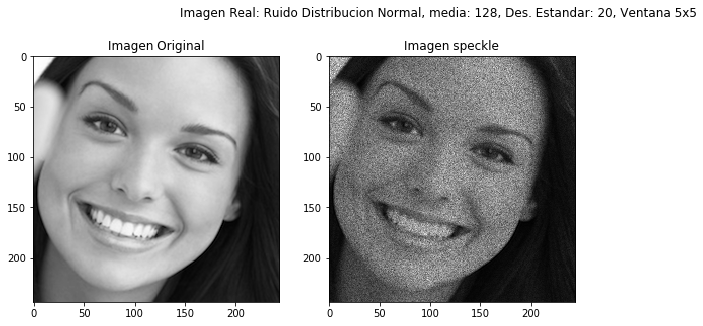

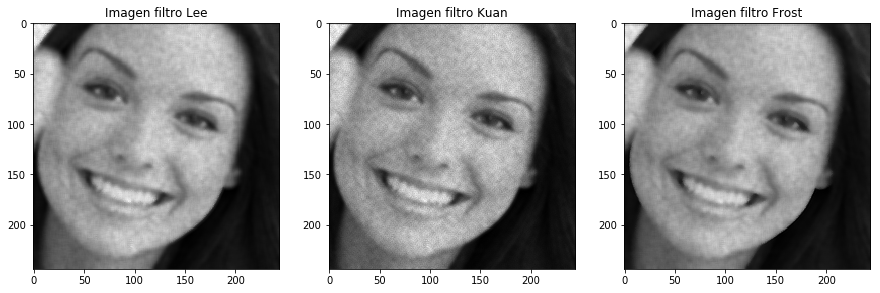

In [12]:
specle_img = speckle(img,128,20) 
lee_img = lee_filter(specle_img,5)
kuan_img = kuan_filter(specle_img,5)
frost_img = frost_filter(specle_img,2,5)

plt.figure(1,figsize=(15,5))
plt.suptitle('Imagen Real: Ruido Distribucion Normal, media: 128, Des. Estandar: 20, Ventana 5x5')
plt.subplot(131), plt.imshow(img, cmap=plt.cm.gray), plt.title('Imagen Original')
plt.subplot(132), plt.imshow(specle_img, cmap=plt.cm.gray), plt.title('Imagen speckle')


plt.figure(2,figsize=(15,5))
plt.subplot(131), plt.imshow(lee_img, cmap=plt.cm.gray), plt.title('Imagen filtro Lee')
plt.subplot(132), plt.imshow(kuan_img, cmap=plt.cm.gray), plt.title('Imagen filtro Kuan')
plt.subplot(133), plt.imshow(frost_img, cmap=plt.cm.gray), plt.title('Imagen filtro Frost')


(<matplotlib.axes._subplots.AxesSubplot at 0x1eb05f28>,
 <matplotlib.text.Text at 0x1f186e10>)

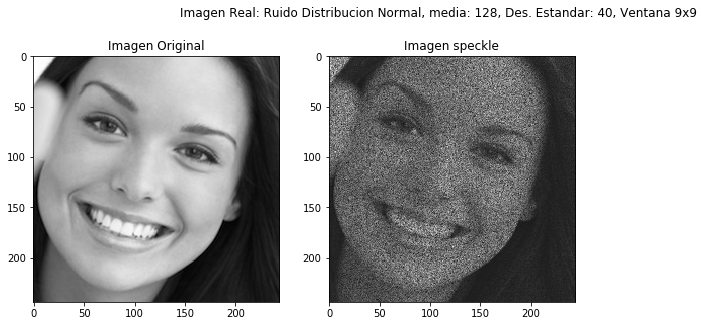

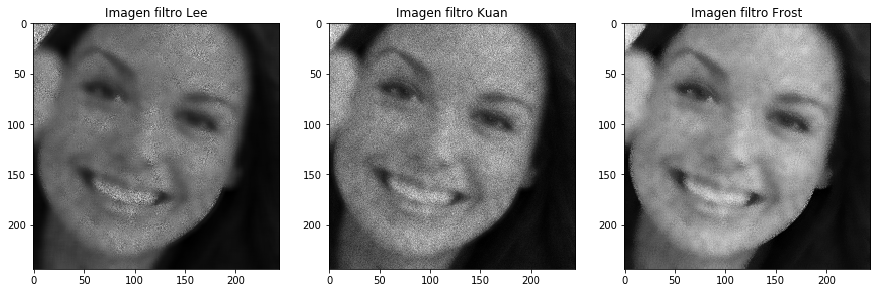

In [13]:
specle_img_2 = speckle(img,128,40) 
lee_img_2 = lee_filter(specle_img_2,9)
kuan_img_2 = kuan_filter(specle_img_2,9)
frost_img_2 = frost_filter(specle_img_2,2,9)

plt.figure(1,figsize=(15,5))
plt.suptitle('Imagen Real: Ruido Distribucion Normal, media: 128, Des. Estandar: 40, Ventana 9x9')
plt.subplot(131), plt.imshow(img, cmap=plt.cm.gray), plt.title('Imagen Original')
plt.subplot(132), plt.imshow(specle_img_2, cmap=plt.cm.gray), plt.title('Imagen speckle')


plt.figure(2,figsize=(15,5))
plt.subplot(131), plt.imshow(lee_img_2, cmap=plt.cm.gray), plt.title('Imagen filtro Lee')
plt.subplot(132), plt.imshow(kuan_img_2, cmap=plt.cm.gray), plt.title('Imagen filtro Kuan')
plt.subplot(133), plt.imshow(frost_img_2, cmap=plt.cm.gray), plt.title('Imagen filtro Frost')

(<matplotlib.axes._subplots.AxesSubplot at 0x1f7b1080>,
 <matplotlib.text.Text at 0x1fe1abe0>)

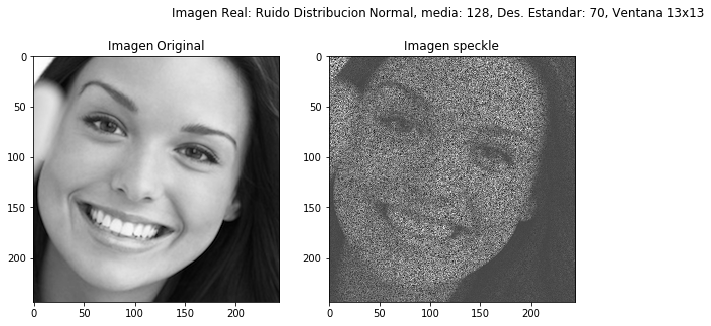

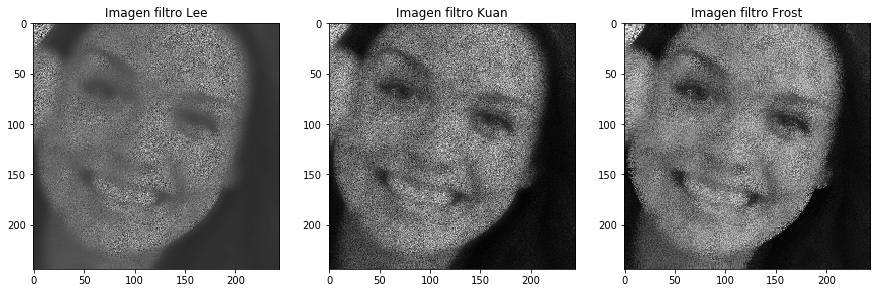

In [14]:
specle_img_3 = speckle(img,128,70) 
lee_img_3 = lee_filter(specle_img_3,13)
kuan_img_3 = kuan_filter(specle_img_3,13)
frost_img_3 = frost_filter(specle_img_3,2,13)

plt.figure(1,figsize=(15,5))
plt.suptitle('Imagen Real: Ruido Distribucion Normal, media: 128, Des. Estandar: 70, Ventana 13x13')
plt.subplot(131), plt.imshow(img, cmap=plt.cm.gray), plt.title('Imagen Original')
plt.subplot(132), plt.imshow(specle_img_3, cmap=plt.cm.gray), plt.title('Imagen speckle')


plt.figure(2,figsize=(15,5))
plt.subplot(131), plt.imshow(lee_img_3, cmap=plt.cm.gray), plt.title('Imagen filtro Lee')
plt.subplot(132), plt.imshow(kuan_img_3, cmap=plt.cm.gray), plt.title('Imagen filtro Kuan')
plt.subplot(133), plt.imshow(frost_img_3, cmap=plt.cm.gray), plt.title('Imagen filtro Frost')

(<matplotlib.axes._subplots.AxesSubplot at 0x1f63eef0>,
 <matplotlib.text.Text at 0x1c018198>)

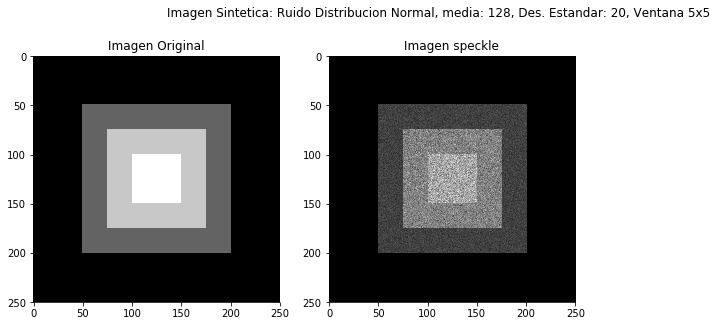

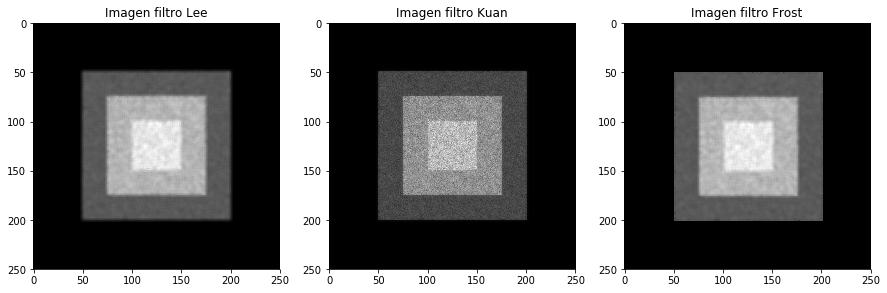

In [15]:
#Imagen sintetica

check = np.ones((250, 250))
check[50:200, 50:200] = 100
check[75:175, 75:175] = 200
check[100:150, 100:150] = 255

specle_img_S = speckle(check,128,20) 


plt.figure(1,figsize=(15,5))
plt.suptitle('Imagen Sintetica: Ruido Distribucion Normal, media: 128, Des. Estandar: 20, Ventana 5x5')
plt.subplot(131), plt.imshow(check, cmap=plt.cm.gray), plt.title('Imagen Original')
plt.subplot(132), plt.imshow(specle_img_S, cmap=plt.cm.gray), plt.title('Imagen speckle')

lee_img_S = lee_filter(specle_img_S,5)
kuan_img_S = kuan_filter(specle_img_S,5)
frost_img_S = frost_filter(specle_img_S,2,5)



plt.figure(2,figsize=(15,5))
plt.subplot(131), plt.imshow(lee_img_S, cmap=plt.cm.gray), plt.title('Imagen filtro Lee')
plt.subplot(132), plt.imshow(kuan_img_S, cmap=plt.cm.gray), plt.title('Imagen filtro Kuan')
plt.subplot(133), plt.imshow(frost_img_S, cmap=plt.cm.gray), plt.title('Imagen filtro Frost')




(<matplotlib.axes._subplots.AxesSubplot at 0x1c2cd438>,
 <matplotlib.text.Text at 0x20c39e10>)

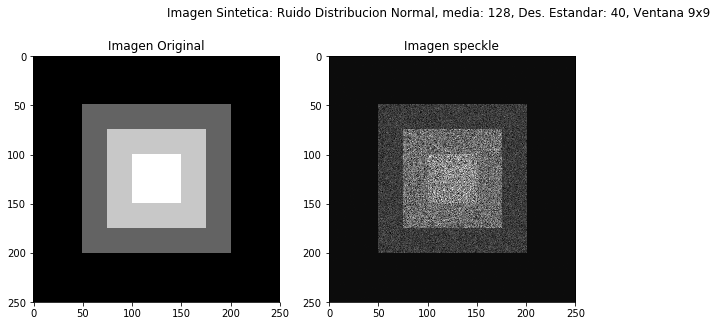

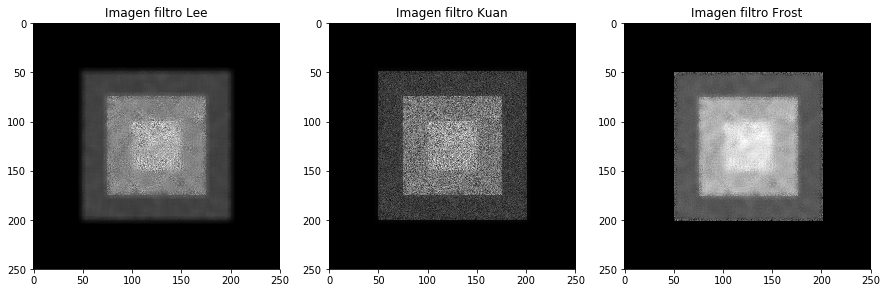

In [16]:
specle_img_S_2 = speckle(check,128,40) 


plt.figure(1,figsize=(15,5))
plt.suptitle('Imagen Sintetica: Ruido Distribucion Normal, media: 128, Des. Estandar: 40, Ventana 9x9')
plt.subplot(131), plt.imshow(check, cmap=plt.cm.gray), plt.title('Imagen Original')
plt.subplot(132), plt.imshow(specle_img_S_2, cmap=plt.cm.gray), plt.title('Imagen speckle')

lee_img_S_2 = lee_filter(specle_img_S_2,9)
kuan_img_S_2 = kuan_filter(specle_img_S_2,9)
frost_img_S_2 = frost_filter(specle_img_S_2,2,9)



plt.figure(2,figsize=(15,5))
plt.subplot(131), plt.imshow(lee_img_S_2, cmap=plt.cm.gray), plt.title('Imagen filtro Lee')
plt.subplot(132), plt.imshow(kuan_img_S_2, cmap=plt.cm.gray), plt.title('Imagen filtro Kuan')
plt.subplot(133), plt.imshow(frost_img_S_2, cmap=plt.cm.gray), plt.title('Imagen filtro Frost')


(<matplotlib.axes._subplots.AxesSubplot at 0x21435a20>,
 <matplotlib.text.Text at 0x21a9a5c0>)

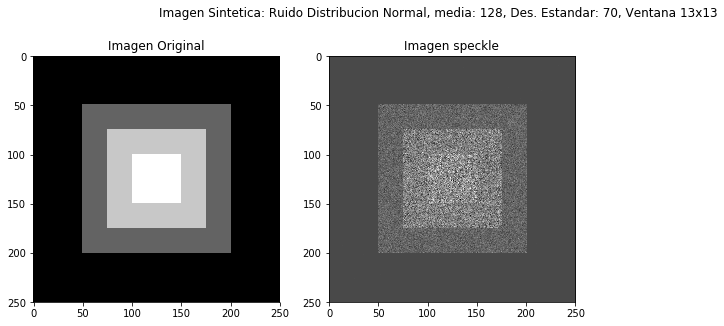

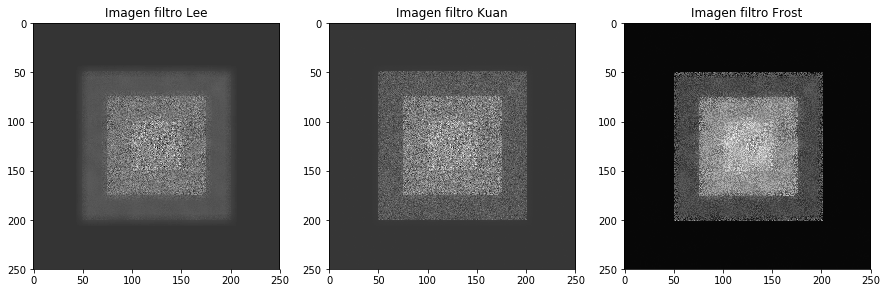

In [17]:
specle_img_S_3 = speckle(check,128,70) 


plt.figure(1,figsize=(15,5))
plt.suptitle('Imagen Sintetica: Ruido Distribucion Normal, media: 128, Des. Estandar: 70, Ventana 13x13')
plt.subplot(131), plt.imshow(check, cmap=plt.cm.gray), plt.title('Imagen Original')
plt.subplot(132), plt.imshow(specle_img_S_3, cmap=plt.cm.gray), plt.title('Imagen speckle')

lee_img_S_3 = lee_filter(specle_img_S_3,13)
kuan_img_S_3 = kuan_filter(specle_img_S_3,13)
frost_img_S_3 = frost_filter(specle_img_S_3,2,13)



plt.figure(2,figsize=(15,5))
plt.subplot(131), plt.imshow(lee_img_S_3, cmap=plt.cm.gray), plt.title('Imagen filtro Lee')
plt.subplot(132), plt.imshow(kuan_img_S_3, cmap=plt.cm.gray), plt.title('Imagen filtro Kuan')
plt.subplot(133), plt.imshow(frost_img_S_3, cmap=plt.cm.gray), plt.title('Imagen filtro Frost')


In [18]:
# Medidas de desempeno
print "#----------------------------------------------  IMAGEN REAL -----------------------------------------------#"
print "\t\t\t\t\t\tImagen Original"
all_mesoures([img,img,img],img,img)

print "\t\t\t\t\t\tPrimera Imagen"
all_mesoures([lee_img,kuan_img,frost_img],img,specle_img)

print "\t\t\t\t\t\tSegunda Imagen"
all_mesoures([lee_img_2,kuan_img_2,frost_img_2],img,specle_img_2)

print "\t\t\t\t\t\tTercera Imagen"
all_mesoures([lee_img_3,kuan_img_3,frost_img_3],img,specle_img_3)



#----------------------------------------------  IMAGEN REAL -----------------------------------------------#
						Imagen Original
#---------------------------------------------------------------------------------------------------------#
#   				LEE				KUAN				FROST
SNR				1.85013342847			1.85013342847			1.85013342847
ENL				1051.73858648			1051.73858648			1051.73858648
SSI				1.0			1.0			1.0
SMPI				1.0			1.0			1.0
Q				1.0			1.0			1.0
#---------------------------------------------------------------------------------------------------------#
						Primera Imagen
#---------------------------------------------------------------------------------------------------------#
#   				LEE				KUAN				FROST
SNR				1.86875969617			1.85948923861			1.8673406257
ENL				809.399672263			396.975859313			903.080381973
SSI				0.228149349696			0.325775708964			0.215991939051
SMPI				24.9990513116			28.8184082108			14.4816618481
Q				0.745966124409			0.365873192303			0.832345099255
#---------------------

### Analisis Metricas imagen real

La imagen original al aplicarles las medidas se puede ver que, los valores de SNR son mayores a 1, esto se debe a que la desviación estándar entre los datos es menor que la media, ya que esta es una imagen que toma diferentes valores en toda la imágenes ENL en este caso es el mayor comparado con los demás casos, ya que la imagen y la imagen filtradas son la misma. El resto de métricas da 1 como es esperado por la teoría.

En la primer imagen con ruido podemos ver que los mejores filtros aparentemente son el de Lee y Frost esto se confirma con el ENL como dice la teoría, entre mayor el valor mejor el filtro obteniendo los mejores valores el filtro de Lee y el de Forst, en la calidad podemos ver que comparado con los demás ruidos, este fue el que tubo valores mas altos.

En los demas casos de ruido se puede ver que todas las metricas empeoran con respecto al primer caso, pero se puede ver que se mantiene una relacion en el SNR, otra cosa a destacar es que a medida que el ruido aumenta, el filtro de Lee pasa a ser peor que el de Kuan.

In [19]:
print "#----------------------------------------------  IMAGEN SINTETICA ------------------------------------------#"
print "\t\t\t\t\t\tImagen Original"
all_mesoures([check,check,check],check,check,cx=0.5,cy=0.3,winS=10)

print "\t\t\t\t\t\tPrimera Imagen"
all_mesoures([lee_img_S,kuan_img_S,frost_img_S],check,specle_img_S)

print "\t\t\t\t\t\tSegunda Imagen"
all_mesoures([lee_img_S_2,kuan_img_S_2,frost_img_S_2],check,specle_img_S_2)

print "\t\t\t\t\t\tTercera Imagen"
all_mesoures([lee_img_S_3,kuan_img_S_3,frost_img_S_3],check,specle_img_S_3)




#----------------------------------------------  IMAGEN SINTETICA ------------------------------------------#
						Imagen Original
#---------------------------------------------------------------------------------------------------------#
#   				LEE				KUAN				FROST
SNR				0.685810056234			0.685810056234			0.685810056234
ENL				9.0			9.0			9.0
SSI				1.0			1.0			1.0
SMPI				1.0			1.0			1.0
Q				1.0			1.0			1.0
#---------------------------------------------------------------------------------------------------------#
						Primera Imagen
#---------------------------------------------------------------------------------------------------------#
#   				LEE				KUAN				FROST
SNR				0.691052920206			0.681663424831			0.685713140375
ENL				851.450869363			77.1432963688			910.198392675
SSI				0.211702921738			0.703327424819			0.204756933268
SMPI				12.4585484416			15.2694408259			8.59033403344
Q				1.26896421976e-20			1.14966794018e-21			1.35649682004e-20
#-----------------------------------

### Analisis Metricas imagen sintetica
La imagen original al aplicarles las medidas se puede ver que los valores dan cosas extrañas, esto se debe a que la desviación estándar de la imagen sintética es 0, esto se debe a que la ventana de datos puede ser completamente de un solo valor, para solucionar esto se puso un valor pequeño remplazando este 0, pero para medir bien el desempeño, la ventana se colocó en una zona intermedia de dos colores . Tiene un comportamiento similar a la imagen real, pero más pequeños al mirar los valores de la imagen sin ruido.

En el caso de comparación visual se puede ver que como en la imagen real, los mejores filtros son el filtro de Lee y el Frost, que también se refleja en el ENL.

Podemos ver que la calidad baja demasiado en la metrica, posiblemente a que al ser un solo valor en la imagen original, el ruido se nota más. Por esta misma razón el SMPI tiene un valor más alto a medida que la imagen tiene más ruido, ya que la imagen filtrada queda muy similar a la imagen con ruido, por lo que la media se conserva.